# Attention-aware CNN Models On COVID-19 Detection
## Xiangsheng Gu

    This project is about combining Bottleneck Attention Module(BAM) to Convolutional Neural Networks models and applying them to classify COVID-19 pneumonia from chest X-ray image dataset. The aim of this project is to compare and evaluate models performance based on their classification accuracy, precision, and recall.

In [1]:
import os
import imp
import sys
import cv2
import json
import torch
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.models as models

from PIL import Image
from tqdm import tqdm
from torch.nn import init
from collections import OrderedDict
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

warnings.filterwarnings('ignore')

## Data preparation, visualization, and preprocessing
    we will borrow publicly-available codes and modify the codes by ourselves.
    https://www.kaggle.com/code/sana306/detection-of-covid-positive-cases-using-dl/notebook

In [2]:
results = ['Normal', 'Lung Opacity', 'Viral Pneumonia', 'COVID']
data_dir = '.'
data = []
for idx, result in enumerate(results):
    result += '/images'
    for file in os.listdir(os.path.join(data_dir, result)):
        result = results[idx]
        data.append(['{}/{}'.format(result, 'images/' + file), result])
        
data = pd.DataFrame(data, columns = ['image_path', 'covid_result'])

data['covid_result'] = data['covid_result'].map({'Normal': 'Negative', 
                                                 'Lung Opacity': 'Lung Opacity', 
                                                 'Viral Pneumonia': 'Viral Pneumonia', 
                                                 'COVID': 'Positive'})

data['image'] = data['image_path'].map(lambda x: np.asarray(Image.open(x).resize((75,75))))
data = data.sample(frac = 1).reset_index(drop = True)

print(f'Total number of image samples: {data.shape[0]}')

Total number of image samples: 21165


In [3]:
data.head(5)

,image_path,covid_result,image
0,Viral Pneumonia/images/Viral Pneumonia-1279.png,Viral Pneumonia,"[[17, 38, 62, 79, 90, 103, 132, 148, 153, 148,..."
1,Normal/images/Normal-8327.png,Negative,"[[213, 191, 186, 188, 189, 191, 193, 198, 203,..."
2,COVID/images/COVID-3363.png,Positive,"[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 25, 7..."
3,Lung Opacity/images/Lung_Opacity-4596.png,Lung Opacity,"[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 4, 3,..."
4,Normal/images/Normal-10176.png,Negative,"[[32, 31, 28, 26, 25, 23, 21, 20, 18, 16, 15, ..."


In [4]:
data.tail(5)

,image_path,covid_result,image
21160,Lung Opacity/images/Lung_Opacity-1963.png,Lung Opacity,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
21161,Normal/images/Normal-5236.png,Negative,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
21162,Viral Pneumonia/images/Viral Pneumonia-810.png,Viral Pneumonia,"[[45, 66, 82, 88, 94, 102, 106, 138, 156, 158,..."
21163,COVID/images/COVID-2912.png,Positive,"[[0, 0, 0, 0, 1, 13, 19, 32, 41, 44, 38, 32, 2..."
21164,Lung Opacity/images/Lung_Opacity-3185.png,Lung Opacity,"[[7, 6, 7, 6, 5, 9, 10, 11, 13, 19, 15, 6, 5, ..."


Total number of Negative: 10192
Total number of Lung Opacity: 6012
Total number of Viral Pneumonia: 1345
Total number of Positive: 3616
6012 + 1345 + 3616 = 10973


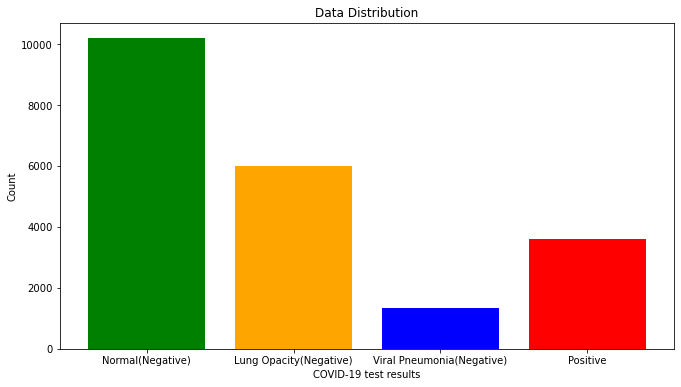

In [5]:
results_count = [len(data[data['covid_result'] == 'Negative']),
                 len(data[data['covid_result'] == 'Lung Opacity']),
                 len(data[data['covid_result'] == 'Viral Pneumonia']),
                 len(data[data['covid_result'] == 'Positive'])]

print(f'Total number of Negative: {results_count[0]}\nTotal number of Lung Opacity: {results_count[1]}')
print(f'Total number of Viral Pneumonia: {results_count[2]}\nTotal number of Positive: {results_count[3]}')
print(f'{results_count[1]} + {results_count[2]} + {results_count[3]} = {results_count[1]+results_count[2]+results_count[3]}')
fig = plt.figure(figsize = (11, 6))

plt.bar(['Normal(Negative)', 'Lung Opacity(Negative)', 'Viral Pneumonia(Negative)', 'Positive'], 
        results_count, color = ['green', 'orange', 'blue', 'red'])

plt.xlabel('COVID-19 test results')
plt.ylabel('Count')
plt.title('Data Distribution')
plt.show()

In [6]:
def image_check(file_path):
    fig = plt.figure(figsize = (5, 5))
    image = cv2.imread(file_path)

    print(f'Image Shape: {image.shape}')
    print(f'Image Height: {image.shape[0]}')
    print(f'Image Width: {image.shape[1]}')
    print(f'Image Dimension: {image.ndim}')
    print(f'Image Size: {image.size//1024} kb\nImage Data Type: {image.dtype}')
    print(f'Maximum RGB value of the image: {image.max()}')
    print(f'Minimum RGB value of the image: {image.min()}')

    plt.imshow(image)
    plt.axis('on')
    plt.show() 
    return 'done.'

Image Shape: (299, 299, 3)
Image Height: 299
Image Width: 299
Image Dimension: 3
Image Size: 261 kb
Image Data Type: uint8
Maximum RGB value of the image: 255
Minimum RGB value of the image: 0


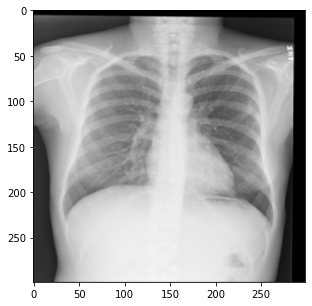

'done.'

In [7]:
image_check(data['image_path'][5])

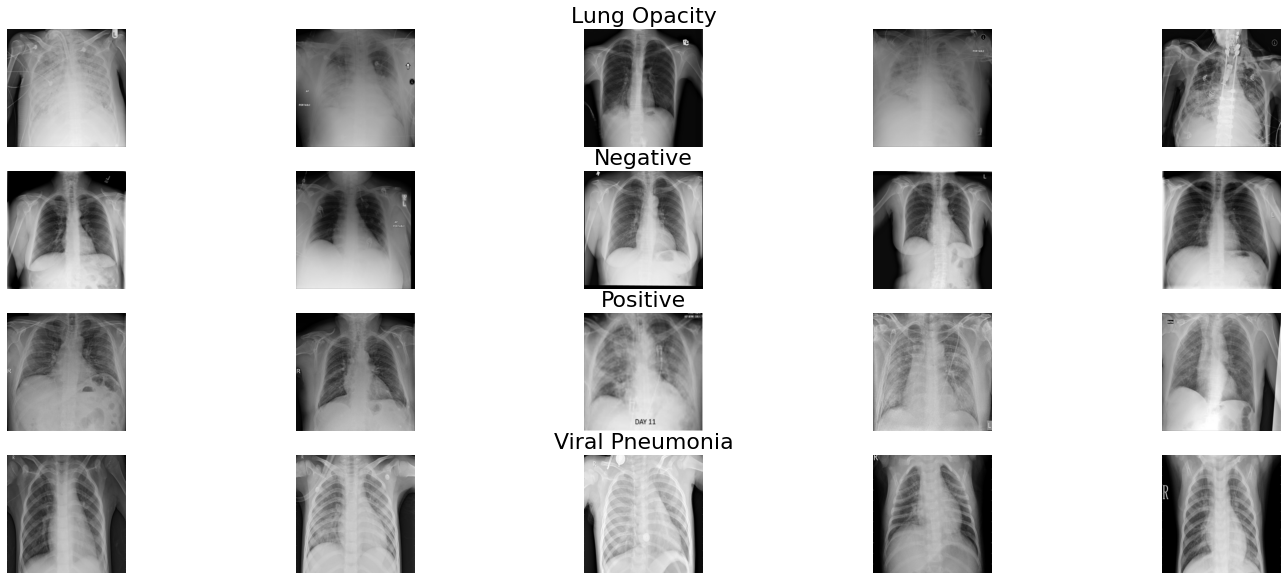

In [8]:
n_samples = 5
fig, m_axs = plt.subplots(4, n_samples, figsize = (5*n_samples, 5*2))

for n_axs, (type_name, type_rows) in zip(m_axs, data.sort_values(['covid_result']).groupby('covid_result')):
    
    n_axs[2].set_title(type_name, fontsize = 22)
    
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state = 5).iterrows()):       
        picture = c_row['image_path']
        image = cv2.imread(picture)
        c_ax.imshow(image)
        c_ax.axis('off')

## Exploratory Data Analysis (EDA)

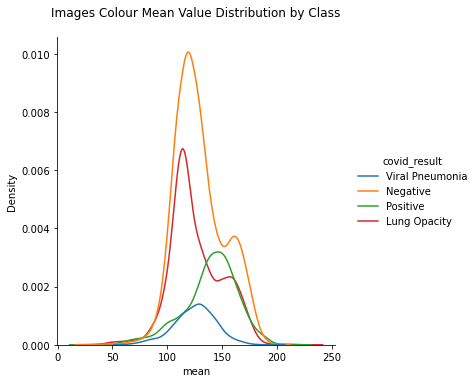

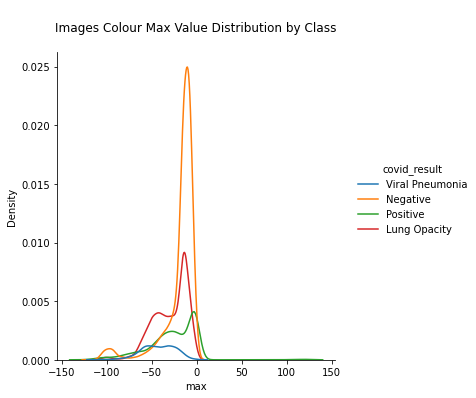

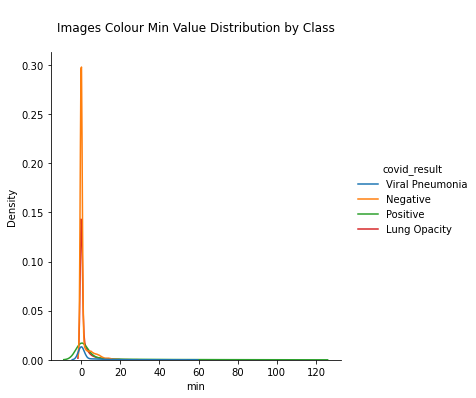

In [9]:
mean_val = []
std_dev_val = []
max_val = []
min_val = []
samples = int(data.shape[0])

for i in range(0, samples):
    mean_val.append(data['image'][i].mean())
    std_dev_val.append(np.std(data['image'][i]))
    max_val.append(data['image'][i].max())
    min_val.append(data['image'][i].min())

imageEDA = data.loc[:,['image','covid_result','image_path']]
imageEDA['mean'] = mean_val
imageEDA['stedev'] = std_dev_val
imageEDA['max'] = max_val
imageEDA['min'] = min_val

imageEDA['subt_mean'] = imageEDA['mean'].mean() - imageEDA['mean']

ax1 = sns.displot(data = imageEDA, x = 'mean', kind="kde", hue = 'covid_result');
plt.title('Images Colour Mean Value Distribution by Class\n', fontsize = 12);

ax2 = sns.displot(data = imageEDA, x = 'max', kind="kde", hue = 'covid_result');
plt.title('\nImages Colour Max Value Distribution by Class\n', fontsize = 12);

ax3 = sns.displot(data = imageEDA, x = 'min', kind="kde", hue = 'covid_result');
plt.title('\nImages Colour Min Value Distribution by Class\n', fontsize = 12);

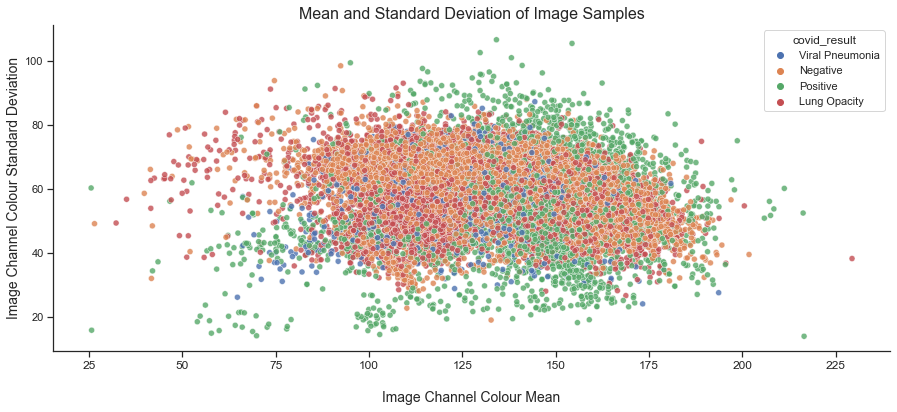

In [10]:
plt.figure(figsize = (15, 6))
sns.set(style = "ticks", font_scale = 1)
ax = sns.scatterplot(data = imageEDA, x = "mean", y = imageEDA['stedev'], hue = 'covid_result', alpha = 0.8);
sns.despine(top = True, right = True, left = False, bottom = False)
plt.xticks(rotation = 0, fontsize = 12)
ax.set_xlabel('\nImage Channel Colour Mean', fontsize = 14)
ax.set_ylabel('Image Channel Colour Standard Deviation', fontsize = 14)
plt.title('Mean and Standard Deviation of Image Samples', fontsize = 16);

## Defining Attention-aware CNNs algorithm and models training

In [11]:
# Reference link: https://github.com/asdf2kr/BAM-CBAM-pytorch

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, hid_channels, atte='cbam', ratio=16, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, hid_channels, stride)
        self.bn1 = nn.BatchNorm2d(hid_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(hid_channels, hid_channels)
        self.bn2 = nn.BatchNorm2d(hid_channels)
        self.downsample = downsample

        if atte == 'cbam':
            self.atte = CBAM(hid_channels, ratio)
        else:
            self.atte = None

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        # CBAM
        if not self.atte is None:
            out = self.atte(out)

        out += residual
        out = self.relu(out)

        return out

class BottleneckBlock(nn.Module): # bottelneck-block, over the 50 layers.
    expansion = 4
    def __init__(self, in_channels, hid_channels, atte='cbam', ratio=16, stride=1, downsample=None):
        super(BottleneckBlock, self).__init__()
        self.downsample = downsample
        out_channels = hid_channels * self.expansion
        self.conv1 = conv1x1(in_channels, hid_channels)
        self.bn1 = nn.BatchNorm2d(hid_channels)

        self.conv2 = conv3x3(hid_channels, hid_channels, stride)
        self.bn2 = nn.BatchNorm2d(hid_channels)

        self.conv3 = conv1x1(hid_channels, out_channels)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

        if atte == 'cbam':
            self.atte = CBAM(out_channels, ratio)
        else:
            self.atte = None

    def forward(self, x):
        residual = x # indentity
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        if not self.atte is None:
            out = self.atte(out)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    '''
    *50-layer
        conv1 (output: 112x112)
            7x7, 64, stride 2
        conv2 (output: 56x56)
            3x3 max pool, stride 2
            [ 1x1, 64  ]
            [ 3x3, 64  ] x 3
            [ 1x1, 256 ]
        cov3 (output: 28x28)
            [ 1x1, 128 ]
            [ 3x3, 128 ] x 4
            [ 1x1, 512 ]
        cov4 (output: 14x14)
            [ 1x1, 256 ]
            [ 3x3, 256 ] x 6
            [ 1x1, 1024]
        cov5 (output: 28x28)
            [ 1x1, 512 ]
            [ 3x3, 512 ] x 3
            [ 1x1, 2048]
        _ (output: 1x1)
            average pool, 100-d fc, softmax
        FLOPs 3.8x10^9
    '''
    def __init__(self, block, layers, num_classes=1000, atte='bam', ratio=16, dilation=4):
        super(ResNet, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        self.layers = layers
        self.in_channels = 64
        self.atte = atte
        self.ratio = ratio
        self.dilation = dilation

        if num_classes == 1000:
            self.conv1 = nn.Sequential(
                nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            )
        else:
            self.conv1 = nn.Sequential(
                nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True)
            )

        if self.atte == 'bam':
            self.bam1 = BAM(64*block.expansion, self.ratio, self.dilation)
            self.bam2 = BAM(128*block.expansion, self.ratio, self.dilation)
            self.bam3 = BAM(256*block.expansion, self.ratio, self.dilation)

        self.conv2 = self.get_layers(block, 64, self.layers[0])
        self.conv3 = self.get_layers(block, 128, self.layers[1], stride=2)
        self.conv4 = self.get_layers(block, 256, self.layers[2], stride=2)
        self.conv5 = self.get_layers(block, 512, self.layers[3], stride=2)
        self.avgPool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        torch.nn.init.kaiming_normal_(self.fc.weight)
        for m in self.state_dict():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        torch.nn.init.kaiming_normal_(self.fc.weight)
        for m in self.state_dict():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def get_layers(self, block, hid_channels, n_layers, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != hid_channels * block.expansion:
            downsample = nn.Sequential(
                    conv1x1(self.in_channels, hid_channels * block.expansion, stride),
                    nn.BatchNorm2d(hid_channels * block.expansion),
            )
        layers = []
        layers.append(block(self.in_channels, hid_channels, self.atte, self.ratio, stride, downsample))
        self.in_channels = hid_channels * block.expansion

        for _ in range(1, n_layers):
            layers.append(block(self.in_channels, hid_channels, self.atte, self.ratio))
        return nn.Sequential(*layers)

    def forward(self, x):
        '''
            Example tensor shape based on resnet101
        '''

        x = self.conv1(x)

        x = self.conv2(x)
        if self.atte == 'bam':
            x = self.bam1(x)

        x = self.conv3(x)
        if self.atte == 'bam':
            x = self.bam2(x)

        x = self.conv4(x)
        if self.atte == 'bam':
            x = self.bam3(x)

        x = self.conv5(x)
        x = self.avgPool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def BAMresnet50(**kwargs):
    return ResNet(BottleneckBlock, [3, 4, 6, 3], **kwargs)

def resnet50(**kwargs):
    return ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)

In [12]:
# Reference link: https://github.com/asdf2kr/BAM-CBAM-pytorch

def conv1x1(in_channels, out_channels, stride=1):
    ''' 1x1 convolution '''
    return nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)

def conv3x3(in_channels, out_channels, stride=1, padding=1, dilation=1):
    ''' 3x3 convolution '''
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=padding, dilation=dilation, bias=False)

def conv7x7(in_channels, out_channels, stride=1, padding=3, dilation=1):
    ''' 7x7 convolution '''
    return nn.Conv2d(in_channels, out_channels, kernel_size=7, stride=stride, padding=padding, dilation=dilation, bias=False)

In [13]:
# Reference link: https://github.com/asdf2kr/BAM-CBAM-pytorch

class BAM(nn.Module):
    def __init__(self, in_channel, reduction_ratio, dilation):
        super(BAM, self).__init__()
        self.hid_channel = in_channel // reduction_ratio
        self.dilation = dilation
        self.globalAvgPool = nn.AdaptiveAvgPool2d(1)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

        self.fc1 = nn.Linear(in_features=in_channel, out_features=self.hid_channel)
        self.bn1_1d = nn.BatchNorm1d(self.hid_channel)
        self.fc2 = nn.Linear(in_features=self.hid_channel, out_features=in_channel)
        self.bn2_1d = nn.BatchNorm1d(in_channel)

        self.conv1 = conv1x1(in_channel, self.hid_channel)
        self.bn1_2d = nn.BatchNorm2d(self.hid_channel)
        self.conv2 = conv3x3(self.hid_channel, self.hid_channel, stride=1, padding=self.dilation, dilation=self.dilation)
        self.bn2_2d = nn.BatchNorm2d(self.hid_channel)
        self.conv3 = conv3x3(self.hid_channel, self.hid_channel, stride=1, padding=self.dilation, dilation=self.dilation)
        self.bn3_2d = nn.BatchNorm2d(self.hid_channel)
        self.conv4 = conv1x1(self.hid_channel, 1)
        self.bn4_2d = nn.BatchNorm2d(1)

    def forward(self, x):
        # Channel attention
        Mc = self.globalAvgPool(x)
        Mc = Mc.view(Mc.size(0), -1)

        Mc = self.fc1(Mc)
        Mc = self.bn1_1d(Mc)
        Mc = self.relu(Mc)

        Mc = self.fc2(Mc)
        Mc = self.bn2_1d(Mc)
        Mc = self.relu(Mc)

        Mc = Mc.view(Mc.size(0), Mc.size(1), 1, 1)

        # Spatial attention
        Ms = self.conv1(x)
        Ms = self.bn1_2d(Ms)
        Ms = self.relu(Ms)

        Ms = self.conv2(Ms)
        Ms = self.bn2_2d(Ms)
        Ms = self.relu(Ms)

        Ms = self.conv3(Ms)
        Ms = self.bn3_2d(Ms)
        Ms = self.relu(Ms)

        Ms = self.conv4(Ms)
        Ms = self.bn4_2d(Ms)
        Ms = self.relu(Ms)

        Ms = Ms.view(x.size(0), 1, x.size(2), x.size(3))
        Mf = 1 + self.sigmoid(Mc * Ms)
        return x * Mf

### Performance Report 

In [14]:
def matrix_Report(ytest_target, ytest_pred):
    print("Confusion Matrix of the Validation Set")
    print("-----------")
    print(confusion_matrix(ytest_target ,ytest_pred))
    print("Precision of the model :\t"+str(precision_score(ytest_target, ytest_pred, average = 'micro')))
    print("Recall of the model    :\t"+str(recall_score(ytest_target, ytest_pred, average = 'micro')))
    print("F1 Score of the model  :\t"+str(f1_score(ytest_target, ytest_pred, average = 'micro')))

### Models Analysis

In [15]:
def Resnet50_Evaluator():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if (torch.cuda.is_available()):
        print(f'Current device:{torch.cuda.current_device()}\nName of device:{torch.cuda.get_device_name(0)}\n')

    # Data Preprocessing
    data_transform = {
        "train": transforms.Compose([transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
        "validation": transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}

    image_path = './dataset/' 
    train_dataset = datasets.ImageFolder(root=os.path.join(image_path, "Train"),
                                         transform=data_transform["train"])
    train_num = len(train_dataset)

    exp_list = train_dataset.class_to_idx

    batch_size = 32
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
    print('Using {} dataloader workers every process'.format(nw))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size, shuffle=True,
                                               num_workers=nw)

    validate_dataset = datasets.ImageFolder(root=os.path.join(image_path, "Test"),
                                            transform=data_transform["validation"])
    val_num = len(validate_dataset)
    validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                                  batch_size=batch_size, shuffle=False,
                                                  num_workers=nw)
    print("using {} images for training, {} images for validation.".format(train_num,
                                                                           val_num))
    
    net = resnet50()
    net.to(device)
    
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr = 0.0001)

    epochs = 20
    best_acc = 0.0
    save_path = './{}Net.pth'.format('Res')
    train_steps = len(train_loader)
    
    # create two lists to store results
    tr_loss_lst = list()
    val_acc_lst = list()    
    
    # training
    for epoch in range(epochs):
        net.train()
        running_loss = 0.0
        train_bar = tqdm(train_loader)
        for step, data in enumerate(train_bar):
            images, labels = data
            optimizer.zero_grad()
            outputs = net(images.to(device))

            pred = torch.argmax(outputs.clone().detach().cpu(),dim=1)    
            loss = loss_function(outputs, labels.to(device))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                     epochs,
                                                                     loss)

        # validating
        net.eval()
        acc = 0.0 
        with torch.no_grad():
            val_bar = tqdm(validate_loader)
            for val_data in val_bar:
                val_images, val_labels = val_data
                outputs = net(val_images.to(device))
                predict_y = torch.max(outputs, dim=1)[1]
                # matrix_Report(val_labels.cpu(), predict_y.cpu())
                acc += torch.eq(predict_y, val_labels.to(device)).sum().item()

        val_accurate = acc / val_num
        train_loss = running_loss / train_steps
        # add to lists
        tr_loss_lst.append(train_loss)
        val_acc_lst.append(val_accurate)
        
        print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
              (epoch + 1, train_loss, val_accurate))

        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(), save_path)

    return [tr_loss_lst, val_acc_lst]

In [16]:
def BAM_Resnet50_Evaluator():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if (torch.cuda.is_available()):
        print(f'Current device:{torch.cuda.current_device()}\nName of device:{torch.cuda.get_device_name(0)}\n')
    
    # Data Preprocessing
    data_transform = {
        "train": transforms.Compose([transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
        "validation": transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}

    image_path = './dataset/' 
    train_dataset = datasets.ImageFolder(root=os.path.join(image_path, "Train"),
                                         transform=data_transform["train"])
    train_num = len(train_dataset)

    exp_list = train_dataset.class_to_idx

    batch_size = 32
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
    print('Using {} dataloader workers every process'.format(nw))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size, shuffle=True,
                                               num_workers=nw)

    validate_dataset = datasets.ImageFolder(root=os.path.join(image_path, "Test"),
                                            transform=data_transform["validation"])
    val_num = len(validate_dataset)
    validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                                  batch_size=batch_size, shuffle=False,
                                                  num_workers=nw)
    print("using {} images for training, {} images for validation.".format(train_num,
                                                                           val_num))
    
    net = BAMresnet50()
    net.to(device)
    
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.0001)

    epochs = 20
    best_acc = 0.0
    save_path = './{}Net.pth'.format('BAM_Res')
    train_steps = len(train_loader)
    
    # create two lists to store results
    tr_loss_lst = list()
    val_acc_lst = list()
    
    # training
    for epoch in range(epochs):
        net.train()
        running_loss = 0.0
        train_bar = tqdm(train_loader)
        for step, data in enumerate(train_bar):
            images, labels = data
            optimizer.zero_grad()
            outputs = net(images.to(device))

            pred = torch.argmax(outputs.clone().detach().cpu(),dim=1)
            loss = loss_function(outputs, labels.to(device))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                     epochs,
                                                                     loss)

        # validating
        net.eval()
        acc = 0.0 
        with torch.no_grad():
            val_bar = tqdm(validate_loader)
            for val_data in val_bar:
                val_images, val_labels = val_data
                outputs = net(val_images.to(device))
                predict_y = torch.max(outputs, dim=1)[1]
                # matrix_Report(val_labels.cpu(), predict_y.cpu())
                acc += torch.eq(predict_y, val_labels.to(device)).sum().item()

        val_accurate = acc / val_num
        train_loss = running_loss / train_steps
        
        # add to lists
        tr_loss_lst.append(train_loss)
        val_acc_lst.append(val_accurate)
        
        print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
              (epoch + 1, train_loss, val_accurate))

        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(), save_path)

    return [tr_loss_lst, val_acc_lst]

### BAM + Resnet50

In [17]:
BAM_Resnet50_lsts = BAM_Resnet50_Evaluator()
BAM_ResNet_tr_loss = BAM_Resnet50_lsts[0]
BAM_ResNet_val_acc = BAM_Resnet50_lsts[1]

Current device:0
Name of device:NVIDIA TITAN RTX

Using 8 dataloader workers every process
using 4040 images for training, 940 images for validation.


100%|██████████| 30/30 [00:07<00:00,  4.00it/s]


[epoch 1] train_loss: 0.895  val_accuracy: 0.861


100%|██████████| 30/30 [00:07<00:00,  3.84it/s]


[epoch 2] train_loss: 0.395  val_accuracy: 0.801


100%|██████████| 30/30 [00:07<00:00,  4.04it/s]


[epoch 3] train_loss: 0.331  val_accuracy: 0.910


100%|██████████| 30/30 [00:07<00:00,  4.02it/s]


[epoch 4] train_loss: 0.262  val_accuracy: 0.902


100%|██████████| 30/30 [00:07<00:00,  3.96it/s]


[epoch 5] train_loss: 0.248  val_accuracy: 0.863


100%|██████████| 30/30 [00:07<00:00,  3.81it/s]


[epoch 6] train_loss: 0.205  val_accuracy: 0.816


100%|██████████| 30/30 [00:07<00:00,  4.01it/s]


[epoch 7] train_loss: 0.189  val_accuracy: 0.840


100%|██████████| 30/30 [00:07<00:00,  4.02it/s]


[epoch 8] train_loss: 0.168  val_accuracy: 0.915


100%|██████████| 30/30 [00:07<00:00,  3.75it/s]


[epoch 9] train_loss: 0.140  val_accuracy: 0.862


100%|██████████| 30/30 [00:07<00:00,  3.83it/s]


[epoch 10] train_loss: 0.133  val_accuracy: 0.917


100%|██████████| 30/30 [00:07<00:00,  4.00it/s]


[epoch 11] train_loss: 0.126  val_accuracy: 0.940


100%|██████████| 30/30 [00:07<00:00,  3.99it/s]


[epoch 12] train_loss: 0.138  val_accuracy: 0.886


100%|██████████| 30/30 [00:07<00:00,  4.03it/s]


[epoch 13] train_loss: 0.099  val_accuracy: 0.913


100%|██████████| 30/30 [00:07<00:00,  3.89it/s]


[epoch 14] train_loss: 0.090  val_accuracy: 0.928


100%|██████████| 30/30 [00:05<00:00,  5.76it/s]


[epoch 15] train_loss: 0.120  val_accuracy: 0.914


100%|██████████| 30/30 [00:05<00:00,  5.77it/s]


[epoch 16] train_loss: 0.088  val_accuracy: 0.921


100%|██████████| 30/30 [00:05<00:00,  5.69it/s]


[epoch 17] train_loss: 0.064  val_accuracy: 0.887


100%|██████████| 30/30 [00:05<00:00,  5.68it/s]


[epoch 18] train_loss: 0.083  val_accuracy: 0.944


100%|██████████| 30/30 [00:05<00:00,  5.84it/s]


[epoch 19] train_loss: 0.072  val_accuracy: 0.796


100%|██████████| 30/30 [00:05<00:00,  5.70it/s]

[epoch 20] train_loss: 0.077  val_accuracy: 0.951


### Resnet50

In [18]:
Resnet50_lsts = Resnet50_Evaluator()
ResNet_tr_loss = Resnet50_lsts[0]
ResNet_val_acc = Resnet50_lsts[1]

Current device:0
Name of device:NVIDIA TITAN RTX

Using 8 dataloader workers every process
using 4040 images for training, 940 images for validation.


100%|██████████| 30/30 [00:03<00:00,  9.67it/s]


[epoch 1] train_loss: 0.900  val_accuracy: 0.695


100%|██████████| 30/30 [00:03<00:00,  9.45it/s]


[epoch 2] train_loss: 0.389  val_accuracy: 0.827


100%|██████████| 30/30 [00:03<00:00,  9.20it/s]


[epoch 3] train_loss: 0.306  val_accuracy: 0.899


100%|██████████| 30/30 [00:03<00:00,  9.17it/s]


[epoch 4] train_loss: 0.268  val_accuracy: 0.889


100%|██████████| 30/30 [00:04<00:00,  6.97it/s]


[epoch 5] train_loss: 0.216  val_accuracy: 0.923


100%|██████████| 30/30 [00:04<00:00,  6.94it/s]


[epoch 6] train_loss: 0.220  val_accuracy: 0.912


100%|██████████| 30/30 [00:04<00:00,  7.29it/s]


[epoch 7] train_loss: 0.200  val_accuracy: 0.935


100%|██████████| 30/30 [00:04<00:00,  7.00it/s]


[epoch 8] train_loss: 0.163  val_accuracy: 0.903


100%|██████████| 30/30 [00:04<00:00,  7.35it/s]


[epoch 9] train_loss: 0.166  val_accuracy: 0.938


100%|██████████| 30/30 [00:04<00:00,  7.17it/s]


[epoch 10] train_loss: 0.122  val_accuracy: 0.871


100%|██████████| 30/30 [00:04<00:00,  7.22it/s]


[epoch 11] train_loss: 0.127  val_accuracy: 0.946


100%|██████████| 30/30 [00:04<00:00,  7.30it/s]


[epoch 12] train_loss: 0.128  val_accuracy: 0.922


100%|██████████| 30/30 [00:04<00:00,  7.13it/s]


[epoch 13] train_loss: 0.105  val_accuracy: 0.894


100%|██████████| 30/30 [00:04<00:00,  7.49it/s]


[epoch 14] train_loss: 0.087  val_accuracy: 0.843


100%|██████████| 30/30 [00:04<00:00,  7.23it/s]


[epoch 15] train_loss: 0.117  val_accuracy: 0.939


100%|██████████| 30/30 [00:04<00:00,  7.29it/s]


[epoch 16] train_loss: 0.072  val_accuracy: 0.941


100%|██████████| 30/30 [00:04<00:00,  7.30it/s]


[epoch 17] train_loss: 0.062  val_accuracy: 0.943


100%|██████████| 30/30 [00:04<00:00,  7.17it/s]


[epoch 18] train_loss: 0.080  val_accuracy: 0.890


100%|██████████| 30/30 [00:04<00:00,  7.16it/s]


[epoch 19] train_loss: 0.055  val_accuracy: 0.946


100%|██████████| 30/30 [00:04<00:00,  7.24it/s]

[epoch 20] train_loss: 0.060  val_accuracy: 0.931


### Classification performance evaluation

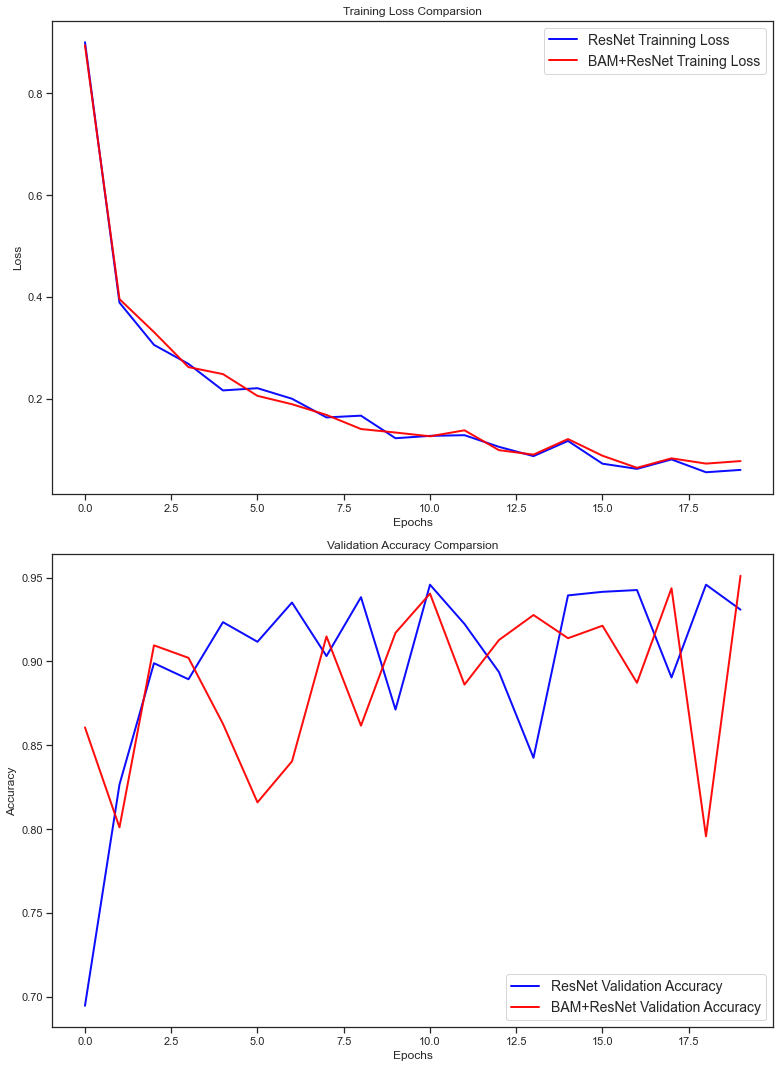

In [21]:
# Epochs
X = [num for num in range(0,20)]

# Comparing models based on training loss and validation accuracy
Y_labels = ['ResNet Trainning Loss','BAM+ResNet Training Loss', 
            'ResNet Validation Accuracy','BAM+ResNet Validation Accuracy']

fig, axs = plt.subplots(2, 1, figsize = (11, 15))
axs = np.atleast_2d(axs)

axs[0, 0].set_title(f'Training Loss Comparsion')

axs[0, 0].plot(X, ResNet_tr_loss, lw = 2, color='blue', alpha=0.95, label = Y_labels[0])
axs[0, 0].plot(X, BAM_ResNet_tr_loss, lw = 2, color='red', alpha=0.95, label = Y_labels[1])

axs[0, 0].set(xlabel = 'Epochs', ylabel = 'Loss')
axs[0, 0].legend(fontsize = 14, loc = 1)

        
axs[0, 1].set_title(f'Validation Accuracy Comparsion')

axs[0, 1].plot(X, ResNet_val_acc, lw = 2, color='blue', alpha=0.95, label = Y_labels[2])
axs[0, 1].plot(X, BAM_ResNet_val_acc, lw = 2, color='red', alpha=0.95, label = Y_labels[3])

axs[0, 1].set(xlabel = 'Epochs', ylabel = 'Accuracy')
axs[0, 1].legend(fontsize = 14, loc = 4)     
      
fig.tight_layout()
plt.show()